In [1]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../../configs/self_play.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../../data/moves_10"'
sys.path.append("../../src")

import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import torch

from neural_net import NeuralNet
from configuration import config, moves_data
from analysis import load_events, filter_events
from display import Display
import player_pov_helpers

Loaded config:  {"development": {"debug_mode": true, "profile": false, "runtime": 72000, "display_logs_in_console": false, "output_directory": "data/2024-11-23_00-37-50-doublehandedness"}, "logging": {"save_interval": 3600, "mcts_report_fraction": 0, "ucb_report": false, "gpu_evaluation": true, "made_move": true}, "game": {"board_size": 10, "num_moves": 6233, "moves_directory": "../../data/moves_10"}, "architecture": {"gameplay_processes": 6, "coroutines_per_process": 256, "game_flush_threshold": 200}, "networks": {"default": {"main_body_channels": 64, "value_head_channels": 16, "value_head_flat_layer_width": 64, "policy_head_channels": 64, "residual_blocks": 8, "model_path": "", "model_directory": "data/2024-11-23_00-37-50-doublehandedness/models/", "new_model_check_interval": 120, "batch_size": 128}}, "training": {"run": true, "network_name": "default", "batch_size": 64, "policy_loss_weight": 0.158, "learning_rate": 0.001, "sample_window": 50000, "samples_per_generation": 10000, "sam

In [7]:
MOVES = moves_data()

In [8]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [4]:
events = load_events("../../data/2024-11-22_16-23-57-pact/logs_2024-11-22_16-29-20_584683.txt")

Start time: 1732321459.322089


In [5]:
for event in events:
    if event.name == "game_end":
        print("Completed a game.")

Completed a game.
Completed a game.
Completed a game.


In [6]:
for event in events:
    if event.name == "loaded_model":
        print(event.params["model_name"])

2024-11-22_09-47-50_646610


In [7]:
mcts_reports = [e.params for e in filter_events(events, "mcts_report")]
ucb_reports = [e.params for e in filter_events(events, "ucb_report")]

In [8]:
target_count = 400

count = 0
for i, report in enumerate(ucb_reports):
    if np.sum(np.array(report["board"])) == 0:
        if count == target_count:
            break
        count += 1

report_index = i

report = ucb_reports[report_index]

In [9]:
report = mcts_reports[52]

In [10]:
board = np.array(report["board"])
children_visit_counts = np.array(report["children_visit_counts"])
children_value_sums = np.array(report["children_value_sums"])
children_priors = np.array(report["children_priors"])
array_index_to_move_index = np.array(report["array_index_to_move_index"])
values = np.array(report["values"])
player = report["player"]

Display(board, MOVES["new_occupieds"][array_index_to_move_index[np.argmax(children_visit_counts)]]).show()
print(player)
print(values)
print(np.sum(board, axis=(1,2)))

NameError: name 'MOVES' is not defined

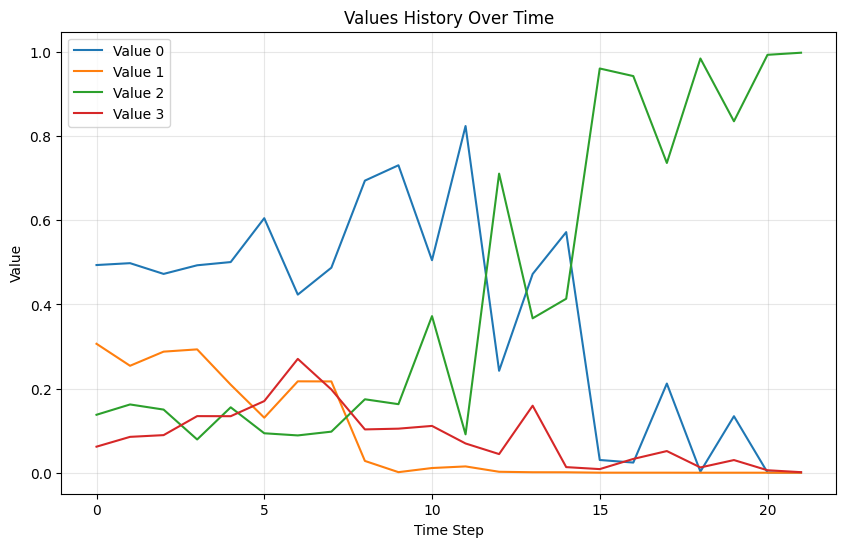

In [677]:
values_history = []
for report in mcts_reports[40:62]:
    values_history.append(np.array(report["values"]))
values_history = np.array(values_history)

plt.figure(figsize=(10, 6))
for i in range(len(values_history[0])):
    plt.plot(range(len(values_history)), values_history[:, i], label=f'Value {i}')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Values History Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


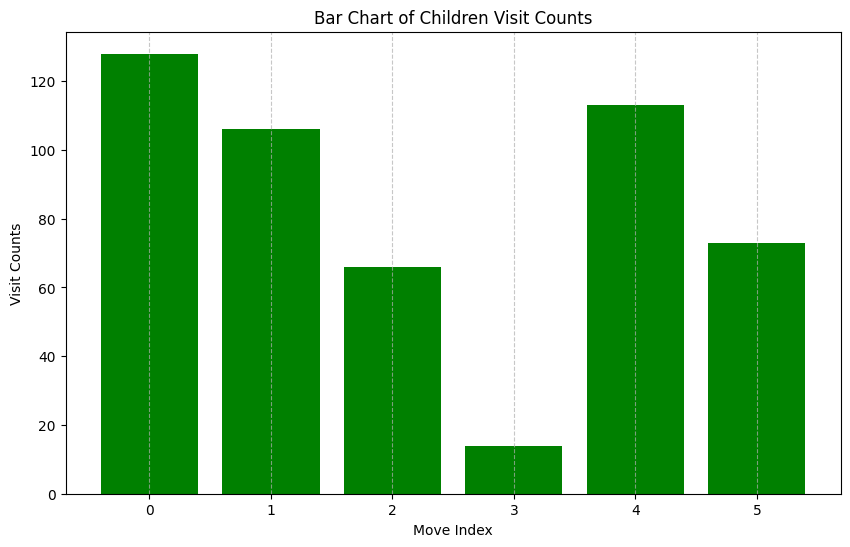

np.int64(500)

In [678]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(children_visit_counts)), children_visit_counts, color='g')
plt.xlabel('Move Index')
plt.ylabel('Visit Counts')
plt.title('Bar Chart of Children Visit Counts')
plt.xticks(ticks=range(0, len(children_visit_counts), max(1, len(children_visit_counts)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

sum(children_visit_counts)

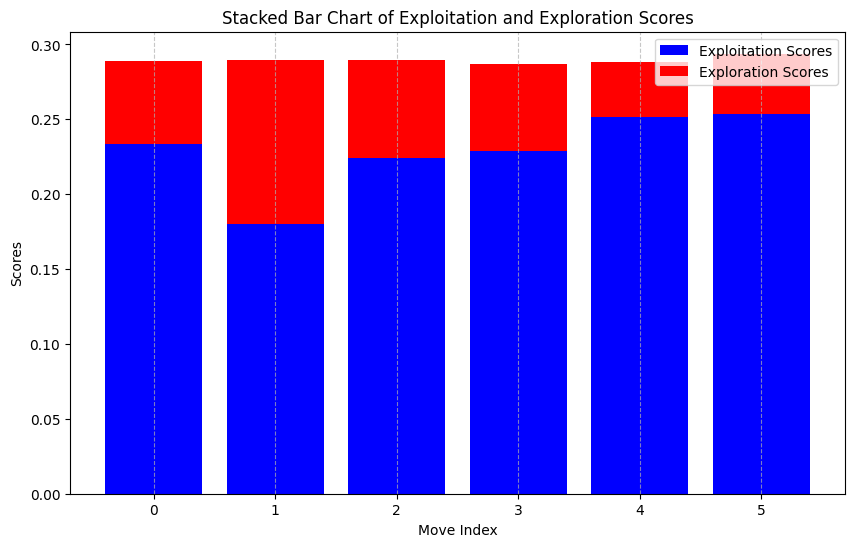

In [679]:
exploitation_scores = np.divide(
    np.array(children_value_sums[player]),
    np.array(children_visit_counts),
    where=children_visit_counts > 0
)
exploitation_scores[children_visit_counts <= 0] = values[player]

sqrt_total_visit_count = np.sqrt(np.sum(children_visit_counts) + 1)
exploration_scores = 1.4 * np.array(children_priors) * sqrt_total_visit_count / (1 + np.array(children_visit_counts))

# Create a stacked bar chart
plt.figure(figsize=(10, 6))
indices = range(len(exploitation_scores))
plt.bar(indices, exploitation_scores, label='Exploitation Scores', color='b')
plt.bar(indices, exploration_scores, bottom=exploitation_scores, label='Exploration Scores', color='r')

plt.xlabel('Move Index')
plt.ylabel('Scores')
plt.title('Stacked Bar Chart of Exploitation and Exploration Scores')
plt.xticks(ticks=range(0, len(exploitation_scores), max(1, len(exploitation_scores)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


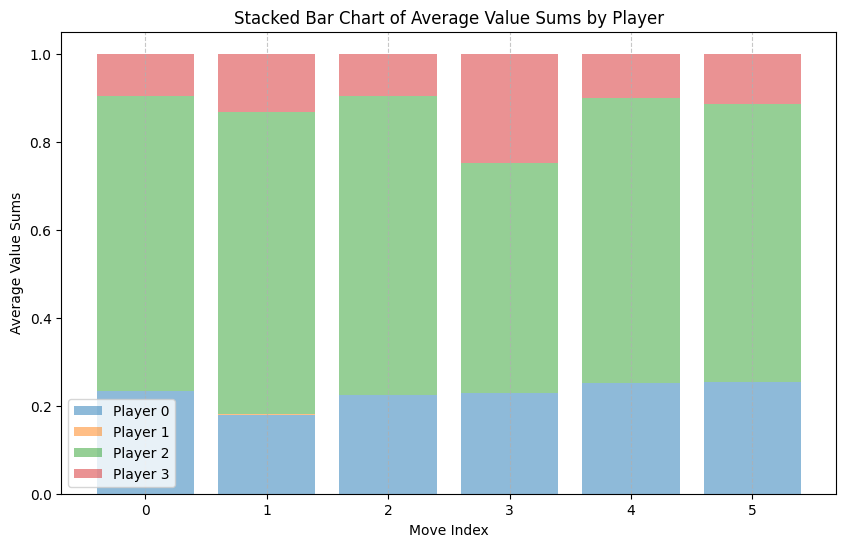

[0.24232823 0.0022545  0.71109462 0.04432269]
0


In [680]:
plt.figure(figsize=(10, 6))
bottom = np.zeros(len(children_value_sums[0]))
for p in range(4):
    average_value_sums = np.array(children_value_sums[p]) / (np.array(children_visit_counts) + 1e-9)  # Avoid division by zero
    plt.bar(range(len(average_value_sums)), average_value_sums, bottom=bottom, alpha=0.5, label=f'Player {p}')
    bottom += average_value_sums
plt.xlabel('Move Index')
plt.ylabel('Average Value Sums')
plt.title('Stacked Bar Chart of Average Value Sums by Player')
plt.xticks(ticks=range(0, len(average_value_sums), max(1, len(average_value_sums)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

print(values)
print(player)

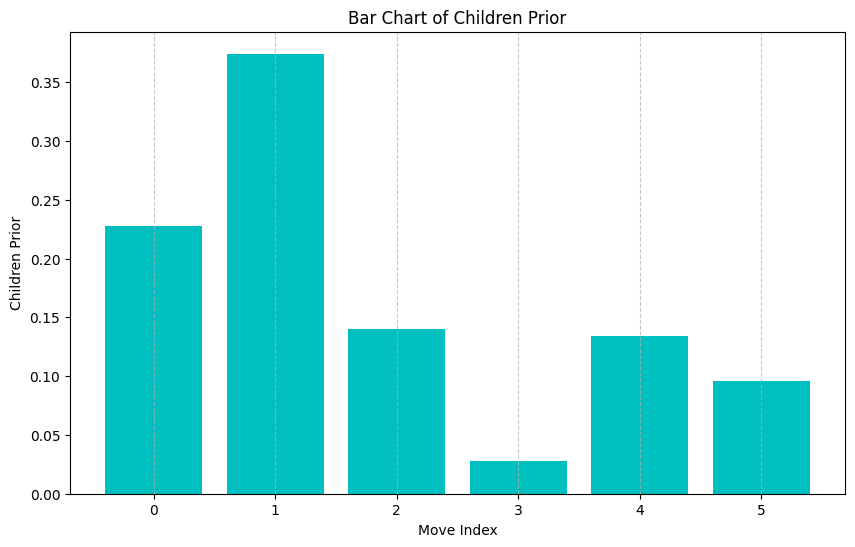

In [681]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(children_priors)), children_priors, color='c')
plt.xlabel('Move Index')
plt.ylabel('Children Prior')
plt.title('Bar Chart of Children Prior')
plt.xticks(ticks=range(0, len(children_priors), max(1, len(children_priors)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

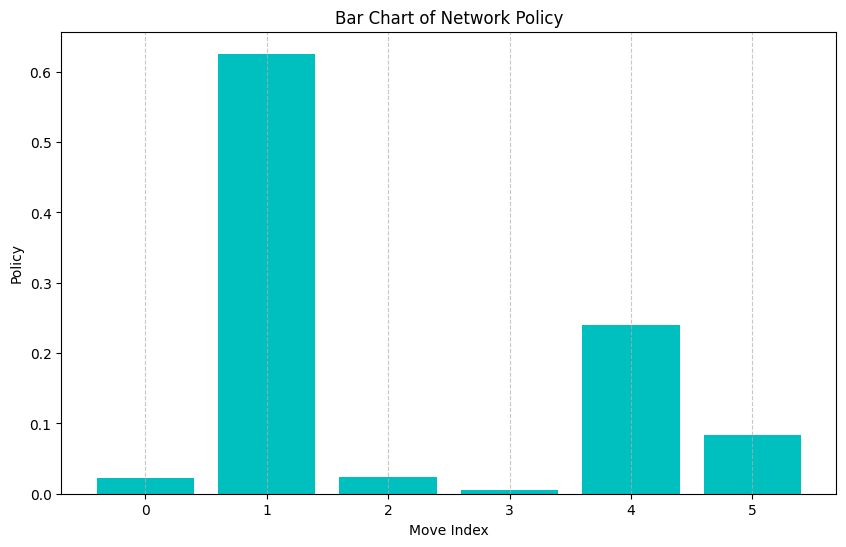

[0.24232823 0.0022545  0.71109462 0.04432269]


In [682]:
model = NeuralNet(config()["networks"]["default"])
# model.load_state_dict(torch.load("../../data/2024-11-19_08-38-28-extracted/models/2024-11-20_09-34-23_478500.pt", weights_only=True))
# model.load_state_dict(torch.load("../../data/2024-11-20_17-29-54-solitude/models/2024-11-20_08-24-43_975055.pt", weights_only=True))
# model.load_state_dict(torch.load("../../data/2024-11-20_14-10-24-survival/models/2024-11-20_02-24-48_055438_s105769.pt", weights_only=True))
# model.load_state_dict(torch.load("../../data/2024-11-20_14-10-24-survival/models/2024-11-20_09-34-23_478500_s313486.pt", weights_only=True))
model.load_state_dict(torch.load("../../data/2024-11-22_00-28-28-overbragging/models/2024-11-22_09-47-50_646610.pt", weights_only=True))

values_logits, policies_logits = model(torch.Tensor(
    player_pov_helpers.occupancies_to_player_pov(board, player)
).unsqueeze(0))

values_logits = values_logits[0].detach().numpy()
policy_logits = policies_logits[0].detach().numpy()

player_pov_values = player_pov_helpers.values_to_player_pov(
    softmax(values_logits),
    -player,
)
policy = softmax(policy_logits[
    player_pov_helpers.moves_indices_to_player_pov(
        array_index_to_move_index,
        player
    )
])

plt.figure(figsize=(10, 6))
plt.bar(range(len(policy)), policy, color='c')
plt.xlabel('Move Index')
plt.ylabel('Policy')
plt.title('Bar Chart of Network Policy')
plt.xticks(ticks=range(0, len(policy), max(1, len(policy)//10)))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(values)

In [683]:
top_10_indices = np.argsort(children_priors)[-10:][::-1]
for i in top_10_indices:
    print(i, np.sum(MOVES["new_occupieds"][i]))

1 5
0 5
2 5
4 5
5 5
3 5


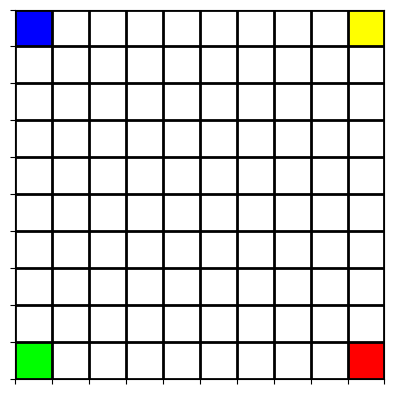

In [2]:
board = np.zeros((4, 10, 10), dtype=bool)
board[0, 0, 0] = True
board[1, 0, 9] = True
board[2, 9, 9] = True
board[3, 9, 0] = True
Display(board).show()

In [3]:
mcts_reports

NameError: name 'children_value_sums' is not defined

In [12]:
children_visit_counts

array([128, 106,  66,  14, 113,  73])

In [19]:
np.sum(children_value_sums, axis=1) / np.sum(children_visit_counts)

array([2.27677515e-01, 4.66751729e-04, 6.60406096e-01, 1.11449643e-01])

In [20]:
values

array([0.24232823, 0.0022545 , 0.71109462, 0.04432269])